Large Steps in Inverse Rendering of Geometry
======================================

This is an example on how to use our method for shape optimization with differentiable rendering. It uses `nvdiffrast` for the differentiable rendering part.

In [1]:
import torch
import torch.nn.functional as F
import os
import cupy as cp

from tqdm import trange
from scripts.load_xml import load_scene
from scripts.geometry import (
    compute_vertex_normals, 
    compute_face_normals,
)
from scripts.render import NVDRenderer

torch.set_printoptions(precision=5, sci_mode=False)

# 0. Loading the scene

Let's start by loading a scene

In [2]:
# Load the scene
filepath = os.path.join(os.getcwd(), "data", "scenes", "centered", "centered.xml")
scene_params = load_scene(filepath)

# Load reference shape
v_ref = scene_params["mesh-target"]["vertices"]
n_ref = scene_params["mesh-target"]["normals"]
f_ref = scene_params["mesh-target"]["faces"]

v_ref, n_ref, f_ref = [f.contiguous() for f in [v_ref, n_ref, f_ref]]
# Load source shape
#v = scene_params["mesh-source"]["vertices"]
#f = scene_params["mesh-source"]["faces"]

# 1. Rendering references

Then, we need to setup a differentiable rendering pipeline. Here, we use an implementation based on `nvdiffrast`:

We initialize it once, so it loads the camera data, the environment map and precomputes the shading model, using spherical harmonics in this case.

In [3]:
# Initialize the renderer
renderer = NVDRenderer(scene_params, shading=True, boost=3)

/home/bobi/Desktop/conjure/scripts/render.py:173: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  pos = 0.5 - torch.stack((pos_int % w, pos_int // w), dim=1) / torch.tensor((w,h), device='cuda')


Let's render the target shape to use as a reference for the optimization:

In [4]:
ref_imgs = renderer.render(v_ref, n_ref, f_ref)

Let's look at one of these references

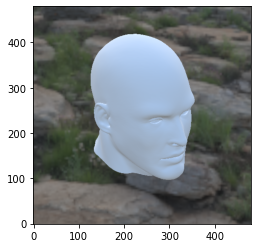

In [5]:
import matplotlib.pyplot as plt
plt.imshow((ref_imgs[7,...,:-1].clip(0,1).pow(1/2.2)).cpu().numpy(), origin='lower')

# 2. Parameterizing

Now it's time to setup the optimization. First, let us import what we need. We need an optimizer, `AdamUniform`, and the functions that allow us to convert back and forth between vertex positions and their parameterization.

In [6]:
from largesteps.parameterize import from_differential, to_differential
from largesteps.geometry import compute_matrix

In [7]:
steps = 1000 # Number of optimization steps
step_size = 0.05 # Step size
lambda_ = 19 # Hyperparameter lambda of our method, used to compute the matrix (I + lambda_*L)

Now we need to parameterize our shape. 

In [8]:
#from src.mesh.ellipsoid import Ellipsoid
from src.mesh.coarse import Coarse
from src.loss.laplacian_loss import LaplacianLoss
from src.loss.edge_loss import EdgeLoss

laplacian_loss = LaplacianLoss(channels=3, padd=True).cuda()
edge_loss = EdgeLoss(False).cuda()

nsz = 32
coarse = Coarse(nsz, kernel=3, sigma=1, r=1.0, ch=256, bias=True).cuda()

#radii = torch.rand(3, device=v_ref.device, requires_grad=True)
v, f, r, stacked = coarse()
# n_ref = compute_face_normals(v_ref, f_ref)
[f.shape for f in [v, f, r, stacked]]

[torch.Size([6144, 3]),
 torch.Size([12284, 3]),
 torch.Size([6, 3, 32, 32]),
 torch.Size([6, 3, 32, 32])]

In [9]:
# self = coarse
# abc = torch.nn.Parameter(torch.zeros(1, 3, 1, 1)).cuda()
# self.radii.shape, abc.shape
# self.radii + abc

In [10]:
# print(coarse.sphere1.shape)

# prev = torch.load('./radii16.pt')
# print(prev.shape)
# prev_scaled = F.interpolate(prev, coarse.sphere1.shape[-1], mode='bilinear', align_corners=True)
# prev_scaled.shape
# coarse.sphere1[:, 2:, :, :] = prev_scaled.cuda()

In [11]:
self = coarse
self.sphere1.shape, self.net(self.sphere1).shape

(torch.Size([6, 5, 38, 38]), torch.Size([6, 3, 32, 32]))

In [12]:
edge_loss = EdgeLoss().cuda()

In [13]:
# Compute the system matrix
M = compute_matrix(v, f, lambda_)

# Parameterize
u = to_differential(M, v)
v.shape, f.shape, u.shape

(torch.Size([6144, 3]), torch.Size([12284, 3]), torch.Size([6144, 3]))

Let's initialize our optimizer, `AdamUniform`

In [14]:
from largesteps.optimize import AdamUniform

In [61]:
#u.requires_grad = True

#opt = AdamUniform(coarse.parameters(), step_size)
opt = torch.optim.Adam(coarse.parameters(),lr=0.03)
#opt = torch.optim.SGD(coarse.parameters(), lr=step_size)

In [62]:
step_size

0.05

In [63]:
# Dictionary that is returned in the end, contains useful information for debug/analysis
v_steps = torch.zeros((steps+1, *v.shape))#, device='cuda')
losses = torch.zeros(steps+1)#, device='cuda')

# 3. Running the optimization

And now we can run our optimization. The only difference with "regular" optimization here is the call to `from_differential` in the loop body, that converts the parameterization to vertex coordinates. The rest of the optimization pipeline is unchanged.

In [64]:
#course.gaussian =  Gaussian(7, sigma=sigma)

In [98]:
def outside_bound(x, minima, maxima):
    mx = torch.tensor(maxima).cuda()
    mi = torch.tensor(minima).cuda()
    mx_mask =  torch.where(x > mx, 1., 0.).detach()
    mi_mask =  torch.where(x < mi, 1., 0.).detach()
    mask = mi_mask + mx_mask
    return (x * mask).abs().mean()

opt.zero_grad()

scale_factor = 1
# Optimization loop

with trange(steps* scale_factor) as tr:
    for it in tr:
        #v, f = ellipsoid(torch.sigmoid(radii) * 2.)
        v, f, radii, stacked  = coarse()
        #bound_loss = outside_bound(radii, -0.5, 0.5)

        if False:
            M = compute_matrix(v, f, lambda_)
            u = to_differential(M, v)

            # Get cartesian coordinates for parameterization
            v = from_differential(M, u, 'Cholesky')

        # Recompute vertex normals
        face_normals = compute_face_normals(v, f)
        n = compute_vertex_normals(v, f, face_normals)

        # Render images
        v, n, f = [f.contiguous()  for f in [v, n, f]]
        opt_imgs = renderer.render(v, n, f)

        # Compute L1 image loss
    #     if bound_loss > 0: 
    #         loss = bound_loss
    #     else:
        rendering_loss = (opt_imgs - ref_imgs).abs().mean()
        radii_loss = laplacian_loss(radii)
        e_loss = edge_loss(stacked)
        loss = rendering_loss \
           + e_loss * 0.5\
           + radii_loss * 0.25 #\
        #print([l.item() for l in  [rendering_loss, e_loss, radii_loss]])
        tr.set_postfix(rendering_loss=rendering_loss.item(), 
                       e_loss=e_loss.item(),
                       radii_loss=radii_loss.item())

        # Record optimization state for later processing
        with torch.no_grad():
            losses[it//scale_factor] = loss.cpu()
            v_steps[it//scale_factor] = v.cpu()

        # Backpropagate
        opt.zero_grad()
        loss.backward()

        # Update parameters
        opt.step()
        #break

100%|██████████| 1000/1000 [00:19<00:00, 51.24it/s, e_loss=0.00105, radii_loss=0.0909, rendering_loss=0.0241]


In [93]:
#torch.save(radii.cpu().detach(), './radii32.pt')
v.shape

torch.Size([6144, 3])

In [79]:
from src.shared.sides import (    
    to_vertices,
    to_stacked,
    make_phi_theta,    
)
face_normals.shape, v.shape
#to_stacked(face_normals.t()).shape

(torch.Size([3, 12284]), torch.Size([6144, 3]))

In [80]:
# #def make_cube_faces(n):
# from src.shared.faces import (
#     make_sides,
#     make_corners,
#     make_edges,
# )
# n = 8
# sides = make_sides(n)
# corners = make_corners(n)
# edges = make_edges(n)
# sides.shape, corners.shape, edges.shape

In [81]:
v.shape, f.shape

(torch.Size([6144, 3]), torch.Size([12284, 3]))

In [82]:
rendering_loss, radii_loss, e_loss

(tensor(0.01428, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.39256, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.00143, device='cuda:0', grad_fn=<DivBackward0>))

In [83]:
n = compute_vertex_normals(v, f, face_normals)
with torch.no_grad():
    # Render images
    opt_imgs = renderer.render(v, n, f)
    # Compute L1 image loss
    loss = (opt_imgs - ref_imgs).abs().mean()
    losses[-1] = loss
    v_steps[-1] = v

# 4. Visualizing the results

In [84]:
from meshplot import plot
from ipywidgets import interact
import numpy as np

In [85]:
v_numpy = v_steps.cpu().numpy()
f_numpy = f.cpu().numpy()

In [86]:
shading_params = {
    "width": 600, 
    "height": 600,
    "antialias": True,
    "colormap": "viridis",
    "wireframe": True,
    "wire_width": 0.03,
    "wire_color": "black",
}

Let's plot the loss:

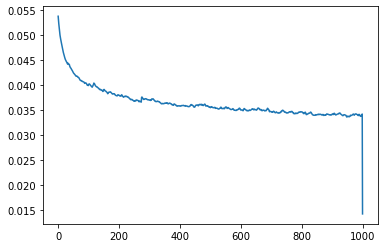

In [94]:
plt.plot(losses.cpu().numpy())

And visualize the mesh across iterations:

In [95]:
@interact(it=(0, steps-1))
def plot_verts(it):
    plot(v_numpy[it], f_numpy, shading=shading_params)

interactive(children=(IntSlider(value=499, description='it', max=999), Output()), _dom_classes=('widget-intera…

In [96]:
import meshplot

In [97]:
meshplot.plot(v.cpu().detach().numpy(), f.cpu().numpy())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.054126…

In [102]:
torch.save(v.cpu().detach(), f'./vertices_{nsz}.pt')

In [104]:
torch.save(stacked.cpu().detach(), f'./stacked_{nsz}.pt')

In [103]:
stacked.shape

torch.Size([6, 3, 32, 32])